# Wave with periodic bc with the scheme from Palma

We solve the wave equation with Dirichlet boundary conditions (homogeneous) up to $T = 2L$ where $L$ is the space size of the integrating region. The data is reflection symmetric, $u_0(x) = u_0(L-x)$, $\partial_t u(x,t=0) = 0$. This way at the last point the solution repeats itself and we can measure the error very well.

In [6]:
import Pkg
#Pkg.add("Zygote")
#Pkg.instantiate()
#Pkg.add("StatsBase")
#Pkg.add("UnPack")
#Pkg.add("Revise")
using ComponentArrays
using Distributions
#using WGLMakie
using Lux
using LuxCUDA
using Optim
using OptimizationOptimJL
using Random
using UnPack
using Zygote
#using CairoMakie  # Backend que funciona en notebooks
using StatsBase
using Revise
using Plots
using JLD2
using NBInclude
#import NaNMath

## Status:

Working well in both GPU and CPU without adaptivity. Using both initial data for u and its derivative.

I put some functions here.

In [7]:
includet("../../neural_tools.jl")
includet("config.jl")

In [8]:

config = config_basic
#config = config_test  # switch to config for real run

@show get_parameter_count(config)


get_parameter_count(config) = 1341


1341

**Note 1:** I attempted to put a bump function of compact support (with some if's) and could not make it run. It seems there are problems with the AD scheme to handle if's. So I put a simpler function.

**Note 2:** As it is, with adaptive it takes 12 hours (CPU) to run... And the solution is wrong...

In [9]:
# -------------------------------------------------------------------
# Second order wave equation (onda 1D): u_tt - c^2 u_xx = 0
# -------------------------------------------------------------------

function wave_equation(∂2u_∂x2, ∂2u_∂t2, config) 
    c = config[:c]
    ∂2u_∂t2 .- (c^2) .* ∂2u_∂x2
end

```
Residual at collocation points
``` 

function residual_at_points_Dirichlet(input, NN, Θ, st)
    x, t = input[1:1, :], input[2:2, :]
    _, u_xx, u_tt = calculate_derivatives_Dirichlet(x, t, NN, Θ, st)
    res = wave_equation(u_xx, u_tt, config)
    #return vec(abs.(res |> cpu_device()))  # magnitud del residuo en CPU
    #return vec(abs.(res))
    return res
end


# -------------------------------------------------------------------
# Loss function with Dirichlet boundary conditions hard enforced.
# -------------------------------------------------------------------

function loss_function(input, NN, Θ, st)
    res = residual_at_points_Dirichlet(input[1], NN, Θ, st)
    return log10(sum(abs2, res) / length(res))
    #return sum(abs2, res) / length(res)
end

# -------------------------------------------------------------------
# Callback
# -------------------------------------------------------------------
function callback(p, l, losses)
    println("Current loss: ", l)
    push!(losses, log10(l))
    return false
end

callback (generic function with 1 method)

Initial data:

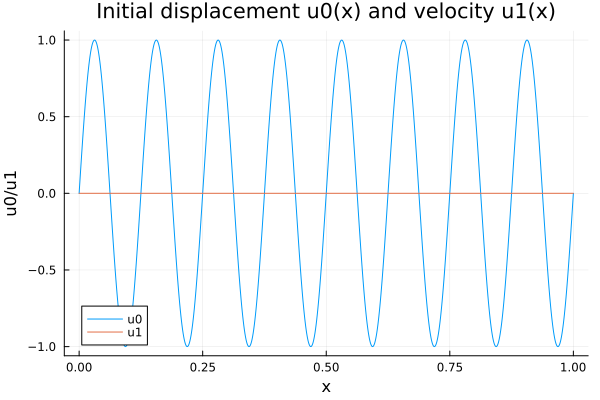

In [12]:
includet("wave_ini_bound_data.jl")

plot(u0, xmin, xmax, title="Initial displacement u0(x) and velocity u1(x)", xlabel="x", ylabel="u0/u1", label="u0")
plot!(u1, xmin, xmax, label="u1")

### Results:

1. With the p=4 polynomial data works OK and the error is of low frequency.
2. With the p=2 sin data it does not work. Start decreasing the loss function but at some point there is a problem with the optimizer and it does not improve further, on the contrary the loss stabilizes in a larger value.
It seems to be going with smaller t evolution (as if the speed were smaller)

In [13]:
input = generate_input_x_t(config)
input0 = generate_input0_x(config)
input_bound = generate_input_boundary_x(config)
input_total = [input, input0, input_bound]

@show typeof(input_total) size(input_total)
@show get_parameter_count(config)

input_cpu = input |> cpu_device()

# plot the inputs is needed
#scatter(input_cpu[1,:], input_cpu[2,:], markersize=1, title="Collocation points", xlabel="x", ylabel="t")

typeof(input_total) = Vector{CuArray{Float64, N, CUDA.DeviceMemory} where N}
size(input_total) = (3,)
get_parameter_count(config) = 1341


2×2000 Matrix{Float64}:
 0.353413  0.650084  0.451858  0.760423  …  0.69395   0.280693  0.257873
 1.62389   1.24098   1.01726   1.8959       0.184678  0.691523  0.266728

In [14]:
# -------------------------------------------------------------------
# Entrenamiento
# -------------------------------------------------------------------
losses = []
NN, Θ, st = create_neural_network(config)


#input_total[1] === input

(Chain{@NamedTuple{layer_1::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_4::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_5::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(2 => 20, tanh), layer_2 = Dense(20 => 20, tanh), layer_3 = Dense(20 => 20, tanh), layer_4 = Dense(20 => 20, tanh), layer_5 = Dense(20 => 1)), nothing), (layer_1 = (weight = [0.7777052521705627 -1.0210886001586914; -1.3711841106414795 -0.07635436952114105; … ; -1.3413087129592896 1.737593412399292; -0.0867929458618164 1.7165613174438477], bias = [-0.5090187788009644, 0.5008149147033691, -0.32147079706192017, -0.281040757894516, -0.5725523829460144, -0.5512858629226685, 0.5049196481704712, -0.542649507522583, -0.4695274531841278, 0.6331928372383118, 0.3604305684566498, -

In [ ]:
#res = residual_at_points_Dirichlet(input_total[1], NN, Θ, st)
#res_cpu = res |> cpu_device()
#@show typeof(res_cpu) size(res_cpu)
#res_cpu

1×2000 CuArray{Float64, 2, CUDA.DeviceMemory}:
 -2235.51  2404.99  -1670.12  1262.46  …  2337.76  -805.157  2524.93  973.445

In [17]:
loss_function(input_total, NN, Θ, st)

6.50216514293797

In [30]:


#calculate_Dirichlet_f(input[1:1, :], input[2:2, :], NN, Θ, st)
#f, ∂2f_∂x2, ∂2f_∂t2 = calculate_derivatives_Dirichlet(input[1:1, :], input[2:2, :], NN, Θ, st)

In [ ]:
Θ, st, losses = compute_solution_1d(config, input_total, NN, Θ, st, losses)
# Parámetros optimizados a CPU si procede
Θ = optresult.u |> cpu_device()

┌ Info: Normal training round 1 / 50  |  iters=500
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 6.50216514293797
Current loss: 6.501710585612309
Current loss: 6.501426383653115
Current loss: 6.5005673998209375
Current loss: 6.499399358488669
Current loss: 6.499148978811314
Current loss: 6.498259352620055
Current loss: 6.497325883086925
Current loss: 6.49443146100407
Current loss: 6.491434080562153
Current loss: 6.484238594492437
Current loss: 6.483391004094427
Current loss: 6.479405592220006
Current loss: 6.476995046977307
Current loss: 6.4701211227213715
Current loss: 6.464656199698354
Current loss: 6.461695840491748
Current loss: 6.4544974475897945
Current loss: 6.451240544906782
Current loss: 6.444286019142293
Current loss: 6.441537538375887
Current loss: 6.440676895467455
Current loss: 6.43609808542191
Current loss: 6.433822451937092
Current loss: 6.430891974357115
Current loss: 6.429770580048005
Current loss: 6.427756190625264
Current loss: 6.42733441730308
Current loss: 6.4258270457273605
Current loss: 6.423528850455751
Current loss: 6.4227668040909975
Current

**Save data:**

In [ ]:
println("Training completed. Saving data")
#@save "wave_Dir_1.jld2" config Θ st losses
#@save "wave_dirichlet_1D_adaptive.jld2" NN Θ st config losses
#@save "wave_dirichlet_1D_u0_sin_u1_zero_p8_SSB.jld2" u0 u1 Θ st config losses
@save "wave_dirichlet_1D_u0_sin_u1_zero_p8_BB.jld2" u0 u1 Θ st config losses
#@save "wave_dirichlet_1D_test.jld2" u0 u1 Θ st config losses 

if in_nbinclude()
    exit()
end

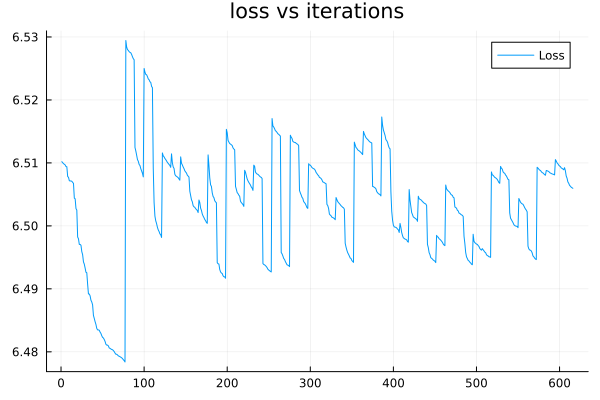

In [75]:
plot(losses, label = "Loss", title = "loss vs iterations") #, yscale = :log10)


In [34]:
losses

config[:tmax]

2.0

In [35]:
NN = create_chain(config)

Chain(
    layer_1 = Dense(2 => 20, tanh),               # 60 parameters
    layer_(2-4) = Dense(20 => 20, tanh),          # 1_260 (420 x 3) parameters
    layer_5 = Dense(20 => 1),                     # 21 parameters
)         # Total: 1_341 parameters,
          #        plus 0 states.

For the initial data with $u_1(x) = \partial_x u_0(x)$ the solution is:

$$ 
u(x,t) = 
\begin{cases}
& u_0(x+t) \;\;\;\; t \leq x \;\;\text{and} \;\;  t \leq 1 - x \\
& u_0(x+t) - u_0(x-t) \;\;\;\;\; t \geq x \;\; \text{and} \;\; t \leq 1 - x \\
& 0 \;\;\;\;\; t \leq x \;\; \text{and} \;\; t \geq 1 - x \\
& - u_0(x-t) \;\;\;\;\; t \geq x \;\; \text{and} \;\; t \geq 1 - x ;\; \text{and} \;\; t \leq 1 + x \\
\end{cases} 
$$

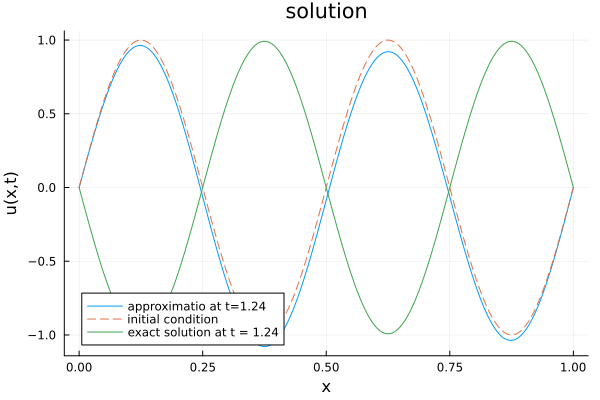

In [36]:
#@unpack xmin, xmax, A, B, p = config
t = 1.24
xs = reshape(collect(range(config[:xmin], config[:xmax], length=200)), 1, :)
t_fix = reshape(fill(t, length(xs)), 1, :)
#sol_p = [calculate_Dirichlet_f(xs, t_fix, NN, Θ, st) for x in xs]
sol_p = [calculate_Dirichlet_f_wf(xs[:,i], t_fix[:,i], NN, Θ, st)[1] for i in 1:length(xs[1,:])]

plot(xs[1,:],sol_p, label = "approximatio at t=$t", title = "solution")
#lines!(xs[1,:],bump.(xs[1,:], config[:x0], config[:x1], config[:p], config[:A]), label = "initial condition")
plot!(xs[1,:],u0(xs[1,:]), label = "initial condition", linestyle = :dash)  
plot!(xlabel = "x", ylabel = "u(x,t)")   
plot!(xs[1,:], A*(sin.(2π*(xs[1,:].+t)*p/(xmax - xmin)) + sin.(2π*(xs[1,:].-t)*p/(xmax - xmin)))/2, label = "exact solution at t = $t")  # exact solution at t=2.0


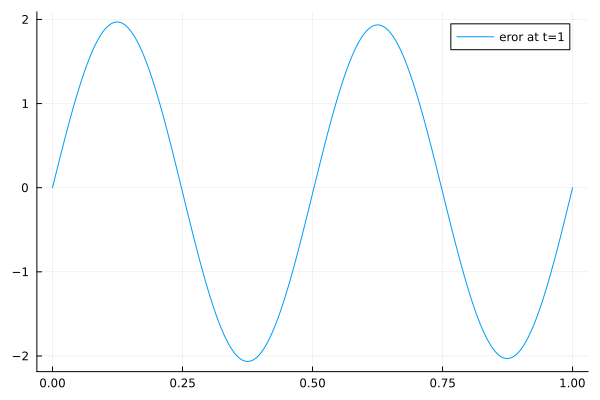

In [37]:
ax = (title = "solution")
t = 1.0
xs = reshape(collect(range(config[:xmin], config[:xmax], length=20000)), 1, :)
t_fix = reshape(fill(t, length(xs)), 1, :)
sol_p = [calculate_Dirichlet_f_wf(xs[:,i], t_fix[:,i], NN, Θ, st)[1] for i in 1:length(xs[1,:])]

plot(xs[1,:],sol_p .+ u0.(xs[1,:]), label = "eror at t=1")